# Gradient boosting model

Current leaderboard score: 0.69361

One, two, you know what to do...

## Notebook set up

### Imports

In [1]:
# Standard library imports
import copy
import sys
from itertools import combinations, permutations
from pathlib import Path

# Third party imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import uniform, randint, loguniform
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, KBinsDiscretizer, PolynomialFeatures

# Add the models directory to path so we can import custom transformers
sys.path.insert(0, '../models')

from gradient_boosting_transformers import (
    IDColumnDropper, IQRClipper, DifferenceFeatures, SumFeatures,
    RatioFeatures, ReciprocalFeatures, LogFeatures, SquareRootFeatures,
    KMeansClusterFeatures
)

### Configuration

In [2]:
TEST_FEATURE_ENGINEERING = False
RUN_HYPERPARAMETER_OPTIMIZATION = False

# Sample sizes, use 1 for full dataset
OPTIMIZATION_SAMPLE = 0.10
EVALUATION_SAMPLE = 0.10
FINAL_TRAINING_SAMPLE = 1.0

# Hyperparameter search and evaluation parameters
CV_FOLDS = 3
N_JOBS = -1
HYPERPARAMETER_SEARCH_ITERATIONS = 200

### Data loading

In [3]:
train_df_path = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/diabetes_prediction_train.csv'

# Load the training dataset
df = pd.read_csv(train_df_path)

# Split test set for internal evaluation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=315)
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

# Display first few rows of training data
train_df.head().transpose()

,0,1,2,3,4
id,661870,241104,119328,426548,309363
age,34,59,53,48,61
alcohol_consumption_per_week,1,2,1,2,4
physical_activity_minutes_per_week,227,85,70,83,43
diet_score,4.7,9.6,5.4,6.0,6.4
sleep_hours_per_day,6.9,6.5,8.0,5.5,7.2
screen_time_hours_per_day,4.1,5.7,4.7,5.0,8.3
bmi,23.6,19.7,23.8,26.6,28.7
waist_to_hip_ratio,0.86,0.77,0.79,0.86,0.87
systolic_bp,101,113,123,119,134


In [4]:
# Display dataset information (columns, dtypes, non-null counts)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  560000 non-null  int64  
 1   age                                 560000 non-null  int64  
 2   alcohol_consumption_per_week        560000 non-null  int64  
 3   physical_activity_minutes_per_week  560000 non-null  int64  
 4   diet_score                          560000 non-null  float64
 5   sleep_hours_per_day                 560000 non-null  float64
 6   screen_time_hours_per_day           560000 non-null  float64
 7   bmi                                 560000 non-null  float64
 8   waist_to_hip_ratio                  560000 non-null  float64
 9   systolic_bp                         560000 non-null  int64  
 10  diastolic_bp                        560000 non-null  int64  
 11  heart_rate                

In [5]:
train_df.nunique()

id                                    560000
age                                       71
alcohol_consumption_per_week               9
physical_activity_minutes_per_week       558
diet_score                                99
sleep_hours_per_day                       69
screen_time_hours_per_day                151
bmi                                      230
waist_to_hip_ratio                        35
systolic_bp                               71
diastolic_bp                              54
heart_rate                                59
cholesterol_total                        153
hdl_cholesterol                           68
ldl_cholesterol                          148
triglycerides                            226
gender                                     3
ethnicity                                  5
education_level                            4
income_level                               5
smoking_status                             3
employment_status                          4
family_his

### Column definitions

In [6]:
# Define the label
label = 'diagnosed_diabetes'

# Define numerical features to apply IQR clipping
numerical_features = [
    'age', 'physical_activity_minutes_per_week', 'diet_score',
    'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
    'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
    'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
]

# Define features for one-hot encoding
nominal_features = [
    'gender', 'ethnicity', 'smoking_status', 'employment_status'
]

# Define ordinal features to encode
ordinal_features = [
    'education_level', 'income_level', 'alcohol_consumption_per_week',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history'
]

# Define ordinal categories in order
education_categories = ['No formal', 'Highschool', 'Graduate', 'Postgraduate']
income_categories = ['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']
alcohol_categories = [1, 2, 3, 4, 5, 6, 7, 8, 9]
diabetes_history_categories = [0, 1]
hypertension_history_categories = [0, 1]
cardiovascular_history_categories = [0, 1]

ordinal_categories = [
    education_categories,
    income_categories,
    alcohol_categories,
    diabetes_history_categories,
    hypertension_history_categories,
    cardiovascular_history_categories
]

# Define features for KMeans clustering
heart_features = ['systolic_bp', 'diastolic_bp', 'heart_rate', 'hypertension_history', 'cardiovascular_history']
cholesterol_features = ['cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides']
lifestyle_features = [
    'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day',
    'screen_time_hours_per_day', 'alcohol_consumption_per_week'
]


## 1. Data Preprocessing

In [7]:
if TEST_FEATURE_ENGINEERING:

    # Drop ID column
    train_df.drop(columns=['id'], inplace=True)
    test_df.drop(columns=['id'], inplace=True)

    print(f'ID column removed')
    print(f'Remaining columns: {list(train_df.columns)}')

### 2.1. Ordinal encoding

In [8]:
if TEST_FEATURE_ENGINEERING:

    # Create ordinal encoder with categories
    ordinal_encoder = OrdinalEncoder(
        categories=ordinal_categories,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )

    # Fit and transform ordinal features
    ordinal_encoded = ordinal_encoder.fit_transform(train_df[ordinal_features])
    train_df.drop(columns=ordinal_features, inplace=True)
    train_df[ordinal_features] = ordinal_encoded

    # And the test data
    ordinal_encoded = ordinal_encoder.transform(test_df[ordinal_features])
    test_df.drop(columns=ordinal_features, inplace=True)
    test_df[ordinal_features] = ordinal_encoded

### 2.2. Nominal encoding

In [9]:
if TEST_FEATURE_ENGINEERING:

    # Create one-hot encoder
    onehot_encoder = OneHotEncoder(
        drop='first',
        sparse_output=False,
        handle_unknown='ignore'
    )

    # Convert encoded features to DataFrame
    encoded_features_df = pd.DataFrame(
        onehot_encoder.fit_transform(train_df[nominal_features]),
        columns=onehot_encoder.get_feature_names_out(nominal_features)
    )

    # Remove original nominal features and add encoded versions
    train_df = pd.concat([train_df.drop(columns=nominal_features), encoded_features_df], axis=1)

    # And the test data
    encoded_features_df = pd.DataFrame(
        onehot_encoder.transform(test_df[nominal_features]),
        columns=onehot_encoder.get_feature_names_out(nominal_features)
    )

    test_df = pd.concat([test_df.drop(columns=nominal_features), encoded_features_df], axis=1)

## 3. Feature engineering

In [10]:
if TEST_FEATURE_ENGINEERING:

    features = train_df.drop(columns=[label]).columns.tolist()

### 3.1. Feature discretization

In [11]:
if TEST_FEATURE_ENGINEERING:

    # Create a KbinsDiscretizer
    binning_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal')

    # Bin the numerical features
    binned_features = binning_transformer.fit_transform(train_df[numerical_features])

    # Add new binned features to the training DataFrame
    binned_features_df = pd.DataFrame(binned_features, columns=[f'binned_{feature}' for feature in numerical_features])
    train_df = pd.concat([train_df, binned_features_df], axis=1)

    # And the test data
    binned_features = binning_transformer.transform(test_df[numerical_features])
    binned_features_df = pd.DataFrame(binned_features, columns=[f'binned_{feature}' for feature in numerical_features])
    test_df = pd.concat([test_df, binned_features_df], axis=1)

### 3.2. Clustering

#### 3.2.1. Heart health clusters

In [12]:
if TEST_FEATURE_ENGINEERING:

    # Fit KMean clustering model on the training data
    kmeans_model = KMeans(n_clusters=4, random_state=315)
    kmeans_model.fit(train_df[heart_features], train_df[label])

    # Add cluster membership as a new feature
    train_df['heart_cluster'] = kmeans_model.predict(train_df[heart_features])
    test_df['heart_cluster'] = kmeans_model.predict(test_df[heart_features])

#### 3.2.2. Cholesterol clusters

In [13]:
if TEST_FEATURE_ENGINEERING:

    # Fit KMean clustering model on the training data
    kmeans_model = KMeans(n_clusters=4, random_state=315)
    kmeans_model.fit(train_df[cholesterol_features], train_df[label])

    # Add cluster membership as a new feature
    train_df['cholesterol_cluster'] = kmeans_model.predict(train_df[cholesterol_features])
    test_df['cholesterol_cluster'] = kmeans_model.predict(test_df[cholesterol_features])

#### 3.2.3. Lifestyle clusters

In [14]:
if TEST_FEATURE_ENGINEERING:

    # Fit KMean clustering model on the training data
    kmeans_model = KMeans(n_clusters=4, random_state=315)
    kmeans_model.fit(train_df[lifestyle_features], train_df[label])

    # Add cluster membership as a new feature
    train_df['lifestyle_cluster'] = kmeans_model.predict(train_df[lifestyle_features])
    test_df['lifestyle_cluster'] = kmeans_model.predict(test_df[lifestyle_features])

### 3.3. Polynomial features

In [15]:
if TEST_FEATURE_ENGINEERING:

    features = train_df.drop(columns=[label]).columns.tolist()

    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

    # Fit and transform the training data
    train_labels = train_df[label].values
    poly_features_train = poly_transformer.fit_transform(train_df[features])
    train_df = pd.DataFrame(poly_features_train, columns=poly_transformer.get_feature_names_out(features))
    train_df[label] = train_labels

    # And the test data
    test_labels = test_df[label].values
    poly_features_test = poly_transformer.transform(test_df[features])
    test_df = pd.DataFrame(poly_features_test, columns=poly_transformer.get_feature_names_out(features))
    test_df[label] = test_labels

### 3.4. Other synthetic features

In [16]:
if TEST_FEATURE_ENGINEERING:

    # Dictionary to collect new features and add at the end
    new_train_features = {}
    new_test_features = {}

#### 3.4.1. Difference features

In [17]:
if TEST_FEATURE_ENGINEERING:

    for feature_a, feature_b in permutations(features, 2):
        feature_name = f'{feature_a}-{feature_b}'
        new_train_features[feature_name] = train_df[feature_a] - train_df[feature_b]
        new_test_features[feature_name] = test_df[feature_a] - test_df[feature_b]

#### 3.4.2. Sum features

In [18]:
if TEST_FEATURE_ENGINEERING:

    for feature_a, feature_b in combinations(features, 2):
        feature_name = f'{feature_a}+{feature_b}'
        new_train_features[feature_name] = train_df[feature_a] + train_df[feature_b]
        new_test_features[feature_name] = test_df[feature_a] + test_df[feature_b]

#### 3.4.3. Ratio features

In [19]:
if TEST_FEATURE_ENGINEERING:

    for feature_a, feature_b in permutations(features, 2):
        feature_name = f'{feature_a}/{feature_b}'
        new_train_features[feature_name] = train_df[feature_a] / (train_df[feature_b] + train_df[feature_b].min() + 1)
        new_test_features[feature_name] = test_df[feature_a] / (test_df[feature_b] + test_df[feature_b].min() + 1)

#### 3.4.4. Reciprocal features

In [20]:
if TEST_FEATURE_ENGINEERING:

    for feature in features:
        feature_name = f'1/{feature}'
        new_train_features[feature_name] = 1 / (train_df[feature] + train_df[feature].min() + 1)
        new_test_features[feature_name] = 1 / (test_df[feature] + test_df[feature].min() + 1)

#### 3.4.5. Log features

In [21]:
if TEST_FEATURE_ENGINEERING:

    for feature in features:
        feature_name = f'log{feature}'
        new_train_features[feature_name] = np.log(train_df[feature] + train_df[feature].min() + 1)
        new_test_features[feature_name] = np.log(test_df[feature] + test_df[feature].min() + 1)

#### 3.4.6. Square root features

In [22]:
if TEST_FEATURE_ENGINEERING:

    for feature in features:
        feature_name = f'root{feature}'
        new_train_features[feature_name] = (train_df[feature] + train_df[feature].min() + 1) ** (1/2)
        new_test_features[feature_name] = (test_df[feature] + test_df[feature].min() + 1) ** (1/2)

#### 3.4.8. Add new features

In [23]:
if TEST_FEATURE_ENGINEERING:

    train_df = pd.concat([train_df, pd.DataFrame(new_train_features)], axis=1)
    test_df = pd.concat([test_df, pd.DataFrame(new_test_features)], axis=1)

### 3.5. Remove constant features

In [24]:
if TEST_FEATURE_ENGINEERING:

    train_df = train_df.loc[:, train_df.nunique() > 1]
    test_df = test_df.loc[:, test_df.columns.isin(train_df.columns)]
    train_df.info()

## 4. Model training and optimization

### 4.1. Sampling

In [25]:
# Draw the first sample without replacement
train_optimization_df = train_df.sample(
    n=int(len(train_df) * OPTIMIZATION_SAMPLE),
    replace=False,
    random_state=315
)

# Get the indices of the remaining rows not in sample1
remaining_indices = train_df.index.difference(train_optimization_df.index)

# Draw the second sample from the *remaining* rows
# We use .loc to select the specific rows from the original df using the remaining indices
train_eval_df = train_df.loc[remaining_indices].sample(
    n=int(len(train_df) * EVALUATION_SAMPLE),
    replace=False,
    random_state=315
)

print(f'Optimization sample shape: {train_optimization_df.shape}')
print(f'Evaluation sample shape: {train_eval_df.shape}')

Optimization sample shape: (56000, 26)
Evaluation sample shape: (56000, 26)


### 4.2. Build Complete Pipeline

Create a scikit-learn pipeline that includes all preprocessing and feature engineering steps.

In [26]:
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif

# Build the complete pipeline
pipeline = Pipeline([

    # Step 1: Drop ID column
    ('drop_id', IDColumnDropper(id_column='id')),
    
    # Step 2: Preprocessing transformations
    ('preprocessing', ColumnTransformer(
        transformers=[

            # Ordinal encoding
            ('ordinal_encoder', OrdinalEncoder(
                categories=ordinal_categories,
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ), ordinal_features),
            
            # One-hot encoding for nominal features
            ('onehot_encoder', OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore'
            ), nominal_features),
            
            # Pass through numerical features (so they're not consumed by clustering/binning)
            ('numerical_passthrough', 'passthrough', numerical_features),
            
            # Binning (discretization) for numerical features
            ('binning', KBinsDiscretizer(
                n_bins=5,
                encode='ordinal',
                strategy='quantile'
            ), numerical_features),
            
            # KMeans clustering for heart features
            ('heart_cluster', KMeansClusterFeatures(
                n_clusters=4,
                random_state=315
            ), heart_features),
            
            # KMeans clustering for cholesterol features
            ('cholesterol_cluster', KMeansClusterFeatures(
                n_clusters=4,
                random_state=315
            ), cholesterol_features),
            
            # KMeans clustering for lifestyle features
            ('lifestyle_cluster', KMeansClusterFeatures(
                n_clusters=4,
                random_state=315
            ), lifestyle_features),
        ],
        remainder='drop'  # Drop any remaining columns
    )),
    
    # Step 3: Feature engineering - create synthetic features in parallel
    ('feature_engineering', FeatureUnion([

        # Keep original features
        ('passthrough', 'passthrough'),
        
        # Polynomial features (degree 2)
        ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
        
        # Difference features
        ('difference', DifferenceFeatures()),
        
        # Sum features
        ('sum', SumFeatures()),
        
        # Ratio features
        ('ratio', RatioFeatures()),
        
        # Reciprocal features
        ('reciprocal', ReciprocalFeatures()),
        
        # Log features
        ('log', LogFeatures()),
        
        # Square root features
        ('sqrt', SquareRootFeatures()),
    ])),
    
    # Step 4: Feature selection - remove low variance and select top features
    ('variance_threshold', VarianceThreshold(threshold=0.01)),
    
    ('select_percentile', SelectPercentile(
        score_func=f_classif,
        percentile=50
    )),
    
    # Step 5: Classifier
    ('classifier', HistGradientBoostingClassifier(random_state=315))
])

pipeline

Pipeline(steps=[('drop_id', IDColumnDropper()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['No '
                                                                              'formal',
                                                                              'Highschool',
                                                                              'Graduate',
                                                                              'Postgraduate'],
                                                                             ['Low',
                                                                              'Lower-Middle',
                                                                              'Middle',
                                                                              'Upper-Middle',
                                                                              'High'],
                                                                             [1,
                                                                              2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9],
                                                                             [0,
                                                                              1],
                                                                             [0,
                                                                              1],
                                                                             [0,
                                                                              1]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['educati...
                                                ('difference',
                                                 DifferenceFeatures()),
                                                ('sum', SumFeatures()),
                                                ('ratio', RatioFeatures()),
                                                ('reciprocal',
                                                 ReciprocalFeatures()),
                                                ('log', LogFeatures()),
                                                ('sqrt',
                                                 SquareRootFeatures())])),
                ('variance_threshold', VarianceThreshold(threshold=0.01)),
                ('select_percentile', SelectPercentile(percentile=50)),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=315))])

### 4.3. Baseline model performance

In [27]:
# Create baseline model from pipeline
baseline_model = copy.deepcopy(pipeline)

# Estimate AUC with cross-validation
baseline_scores = cross_val_score(
    baseline_model,
    train_eval_df.drop(columns=['diagnosed_diabetes']),
    train_eval_df['diagnosed_diabetes'],
    cv=CV_FOLDS,
    scoring=make_scorer(roc_auc_score),
    n_jobs=N_JOBS
)

print(f'Baseline model mean cross-validation score (ROC-AUC): {np.mean(baseline_scores):.4f}')

Baseline model mean cross-validation score (ROC-AUC): 0.6095


### 4.4. Hyperparameter optimization

In [ ]:
%%time

# Best mean cross-validation score (ROC-AUC): 0.7048
#
# N_JOBS = -1
# OPTIMIZATION_SAMPLE = 0.10
# CV_FOLDS = 3
#
# Best parameters:
#   classifier__class_weight: None
#   classifier__early_stopping: True
#   classifier__l2_regularization: 0.16700213384089524
#   classifier__learning_rate: 0.012671253422340085
#   classifier__max_bins: 255
#   classifier__max_depth: 19
#   classifier__max_iter: 401
#   classifier__min_samples_leaf: 28
#   classifier__n_iter_no_change: 50
#   classifier__validation_fraction: 0.1
#   select_percentile__percentile: 61
#   variance_threshold__threshold: 0.00013743694392305273
#
# CPU times: user 21min 50s, sys: 50.5 s, total: 22min 41s
# Wall time: 6h 44s

if RUN_HYPERPARAMETER_OPTIMIZATION:

    # Define parameter distributions for randomized search
    param_distributions = {

        # Feature selection parameters
        'variance_threshold__threshold': uniform(0, 0.1),
        'select_percentile__percentile': randint(25, 76),
        
        # Classifier parameters
        'classifier__learning_rate': loguniform(0.001, 0.3),
        'classifier__max_iter': randint(100, 1001),
        'classifier__max_depth': randint(10, 101),
        'classifier__min_samples_leaf': randint(5, 51),
        'classifier__l2_regularization': loguniform(1e-4, 100.0),
        'classifier__max_bins': [255],
        'classifier__early_stopping': [True],
        'classifier__validation_fraction': [0.1],
        'classifier__n_iter_no_change': [50],
        'classifier__class_weight': ['balanced']
    }

    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        copy.deepcopy(pipeline),
        param_distributions=param_distributions,
        n_iter=HYPERPARAMETER_SEARCH_ITERATIONS,
        cv=CV_FOLDS,
        scoring='roc_auc',
        n_jobs=N_JOBS,
        random_state=315,
        verbose=0
    )

    # Fit the randomized search
    random_search.fit(
        train_optimization_df.drop(columns=['diagnosed_diabetes']),
        train_optimization_df['diagnosed_diabetes']
    )

    # Get the best model from random search
    optimized_model = random_search.best_estimator_

    print(f'\nBest mean cross-validation score (ROC-AUC): {random_search.best_score_:.4f}')
    print(f'\nBest parameters:')

    for param, value in random_search.best_params_.items():
        print(f'  {param}: {value}')

    print()

    # Define model directory and ensure it exists
    model_dir = Path('../models')
    model_dir.mkdir(parents=True, exist_ok=True)

    # Create model filename
    model_name = 'gradient_boosting'
    model_path = model_dir / f'{model_name}.joblib'

    # Save the final model
    joblib.dump(optimized_model, model_path)
    print('Model saved to:', model_path)
    print(f'File size: {model_path.stat().st_size / (1024**2):.2f} MB')
    print()

else:

    # Load the optimized model from file
    model_dir = Path('../models')
    model_name = 'gradient_boosting'
    model_path = model_dir / f'{model_name}.joblib'
    optimized_model = joblib.load(model_path)
    print('Optimized model loaded from:', model_path)
    print()

Optimized model loaded from: ../models/gradient_boosting.joblib
CPU times: user 432 ms, sys: 4.78 ms, total: 437 ms
Wall time: 438 ms


### 4.5. Evaluate optimized model

In [29]:
# Evaluate with cross-validation to verify performance
scores = cross_val_score(
    optimized_model,
    train_eval_df.drop(columns=['diagnosed_diabetes']),
    train_eval_df['diagnosed_diabetes'],
    cv=CV_FOLDS,
    scoring='roc_auc',
    n_jobs=N_JOBS
)

print(f'Optimized model mean cross-validation score (ROC-AUC): {np.mean(scores):.4f}')

Optimized model mean cross-validation score (ROC-AUC): 0.7044


### 4.6. Compare baseline vs optimized performance

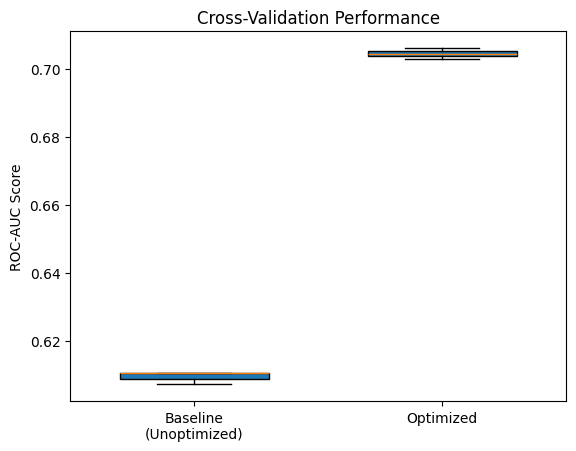

Baseline  - mean score (ROC-AUC): 0.6095, Std: 0.0015
Optimized - mean score (ROC-AUC): 0.7044, Std: 0.0012


In [30]:
# Prepare data for boxplot
comparison_data = [baseline_scores, scores]
labels = ['Baseline\n(Unoptimized)', 'Optimized']

# Create boxplot
plt.title('Cross-Validation Performance')
plt.boxplot(comparison_data, tick_labels=labels, patch_artist=True, widths=0.6)
plt.ylabel('ROC-AUC Score')
plt.show()

# Print summary statistics
print(f'Baseline  - mean score (ROC-AUC): {np.mean(baseline_scores):.4f}, Std: {np.std(baseline_scores):.4f}')
print(f'Optimized - mean score (ROC-AUC): {np.mean(scores):.4f}, Std: {np.std(scores):.4f}')

### 4.7. Confusion matrices

In [ ]:
# Get predictions for both models using cross-validation
baseline_predictions = cross_val_predict(
    baseline_model,
    train_eval_df.drop(columns=['diagnosed_diabetes']),
    train_eval_df['diagnosed_diabetes'],
    cv=CV_FOLDS,
    n_jobs=N_JOBS
)

optimized_predictions = cross_val_predict(
    optimized_model,
    train_eval_df.drop(columns=['diagnosed_diabetes']),
    train_eval_df['diagnosed_diabetes'],
    cv=CV_FOLDS,
    n_jobs=N_JOBS
)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Baseline confusion matrix
axes[0].set_title('Unoptimized model')

disp1 = ConfusionMatrixDisplay.from_predictions(
    train_eval_df['diagnosed_diabetes'],
    baseline_predictions,
    normalize='true',
    ax=axes[0],
    colorbar=False
)

# Optimized confusion matrix
axes[1].set_title('Optimized model')

disp3 = ConfusionMatrixDisplay.from_predictions(
    train_eval_df['diagnosed_diabetes'],
    optimized_predictions,
    normalize='true',
    ax=axes[1],
    colorbar=False
)

plt.tight_layout()
plt.show()

## 5. Final model preparation

### 5.1. Train and evaluate using internal test-train split

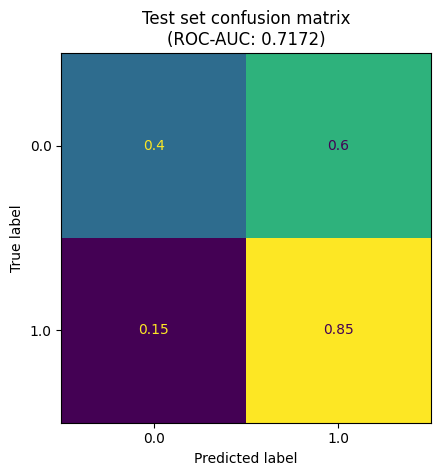

In [33]:
# Fit the optimized model on the training data
optimized_model.fit(
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes']
)

# Make predictions on the test data
test_probabilities = optimized_model.predict_proba(
    test_df.drop(columns=['diagnosed_diabetes'])
)

# Calculate ROC-AUC on the test data
test_roc_auc = roc_auc_score(
    test_df['diagnosed_diabetes'],
    test_probabilities[:, 1]
)

# Make predictions on the test data
test_predictions = optimized_model.predict(
    test_df.drop(columns=['diagnosed_diabetes'])
)

# Show confusion matrix on test data
disp = ConfusionMatrixDisplay.from_predictions(
    test_df['diagnosed_diabetes'],
    test_predictions,
    normalize='true',
    colorbar=False
)

plt.title(f'Test set confusion matrix\n(ROC-AUC: {test_roc_auc:.4f})')
plt.show()

### 5.2. Train on complete dataset

In [34]:
optimized_model.fit(df.drop(columns=['diagnosed_diabetes']), df['diagnosed_diabetes'])

Pipeline(steps=[('drop_id', IDColumnDropper()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['No '
                                                                              'formal',
                                                                              'Highschool',
                                                                              'Graduate',
                                                                              'Postgraduate'],
                                                                             ['Low',
                                                                              'Lower-Middle',
                                                                              'Middle',
                                                                              'Upper-Middle',
                                                                              'High'],
                                                                             [1,
                                                                              2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9],
                                                                             [0,
                                                                              1],
                                                                             [0,
                                                                              1],
                                                                             [0,
                                                                              1]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['educati...
                ('variance_threshold',
                 VarianceThreshold(threshold=0.00013743694392305273)),
                ('select_percentile', SelectPercentile(percentile=61)),
                ('classifier',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                l2_regularization=0.16700213384089524,
                                                learning_rate=0.012671253422340085,
                                                max_depth=19, max_iter=401,
                                                min_samples_leaf=28,
                                                n_iter_no_change=50,
                                                random_state=315))])

## 6. Save Model

In [35]:
# Define model directory and ensure it exists
model_dir = Path('../models')
model_dir.mkdir(parents=True, exist_ok=True)

# Create model filename
model_name = 'gradient_boosting'
model_path = model_dir / f'{model_name}.joblib'

# Save the final model
joblib.dump(optimized_model, model_path)
print('Model saved to:', model_path)
print(f'File size: {model_path.stat().st_size / (1024**2):.2f} MB')

Model saved to: ../models/gradient_boosting.joblib
File size: 12.47 MB


## 7. Save model description

In [36]:
from datetime import datetime

# Create model description filename
markdown_path = '../models/gradient_boosting.md'

# Create markdown description
markdown_content = """# Gradient boosting model for diabetes prediction

## Model overview

This dataset contains a scikit-learn Pipeline object that chains together multiple preprocessing, feature engineering, and modeling steps into a single estimator. Pipelines ensure that all transformations are applied consistently during both training and inference, preventing data leakage and simplifying deployment. The pipeline was optimized using RandomizedSearchCV with extensive hyperparameter tuning.

For details on model optimization and training, see the [gradient boosting optimization and training notebook](https://github.com/gperdrizet/diabetes-prediction/blob/main/notebooks/02.1-gradient_boosting_model.ipynb) on GitHub.

## Files

- **Model file**: `gradient_boosting.joblib` (scikit-learn Pipeline object serialized with joblib)
- **Custom transformers**: `gradient_boosting_transformers.py` (required for model deserialization)
- **Documentation**: `gradient_boosting.md`

Key features:
- **End-to-end processing**: Automatically handles all preprocessing from raw data to predictions
- **Reproducible transformations**: All fitted parameters (encoders, feature engineering, clustering) are preserved
- **Hyperparameter optimization**: Parameters across all pipeline steps were jointly optimized

## Training information

- **Training date**: """ + datetime.now().strftime('%Y-%m-%d %H:%M:%S') + """
- **Training samples**: 700,000
- **Cross-validation**: 3-fold CV with ROC-AUC scoring
- **Optimization method**: RandomizedSearchCV with 200 iterations
- **Optimization samples**: ~70,000 samples (10%) for hyperparameter tuning

## Pipeline components

### 1. Preprocessing

#### ID column removal
- **ID column dropper**: Automatically removes the 'id' column from input data (custom transformer)

#### Numerical features (14 features)
- **Features**: age, physical_activity_minutes_per_week, diet_score, sleep_hours_per_day, screen_time_hours_per_day, bmi, waist_to_hip_ratio, systolic_bp, diastolic_bp, heart_rate, cholesterol_total, hdl_cholesterol, ldl_cholesterol, triglycerides
- **Transformation**: Passed through for feature engineering

#### Ordinal features (6 features)
- **Ordinal encoding**: education_level, income_level, alcohol_consumption_per_week, family_history_diabetes, hypertension_history, cardiovascular_history
- **Method**: OrdinalEncoder with predefined category orders

#### Nominal features (4 features)
- **One-hot encoding**: gender, ethnicity, smoking_status, employment_status
- **Method**: OneHotEncoder (drop first category to avoid multicollinearity)

### 2. Feature engineering

This pipeline creates extensive synthetic features to capture complex relationships:

- **Binning (discretization)**:
  - Bins: 5 quantile-based bins
  - Applied to all 14 numerical features
  - Creates categorical representations of continuous features

- **KMeans clustering** (3 cluster feature sets):
  - **Heart health cluster** (4 clusters): systolic_bp, diastolic_bp, heart_rate, hypertension_history, cardiovascular_history
  - **Cholesterol cluster** (4 clusters): cholesterol_total, hdl_cholesterol, ldl_cholesterol, triglycerides
  - **Lifestyle cluster** (4 clusters): physical_activity_minutes_per_week, diet_score, sleep_hours_per_day, screen_time_hours_per_day, alcohol_consumption_per_week

- **Polynomial features**:
  - Degree: 2
  - Include bias: False
  - Creates interaction terms and squared features

- **Synthetic features** (custom transformers):
  - **Difference features**: All pairwise feature differences (A - B)
  - **Sum features**: All pairwise feature sums (A + B)
  - **Ratio features**: All pairwise feature ratios (A / B)
  - **Reciprocal features**: 1/feature for all features
  - **Log features**: Natural log transform of all features
  - **Square root features**: Square root of all features

### 3. Feature selection

After feature engineering, the pipeline reduces dimensionality:

- **Variance threshold**: Removes low-variance features (optimized threshold)
- **Select percentile**: Keeps top N% of features based on ANOVA F-value (optimized percentage)

### 4. Classifier

- **Algorithm**: HistGradientBoostingClassifier
- **Optimized hyperparameters**:
  - Learning rate: Optimized via log-uniform distribution (0.001 - 0.3)
  - Max iterations: Optimized (100 - 1000 range)
  - Max depth: Optimized (10 - 100 range)
  - Min samples leaf: Optimized (5 - 50 range)
  - L2 regularization: Optimized via log-uniform distribution
  - Class weight: Optimized (None or balanced)
- **Fixed parameters**:
  - Max bins: 255
  - Early stopping: Enabled
  - Validation fraction: 0.1
  - N iter no change: 50

## Custom transformers

The model uses multiple custom scikit-learn transformers defined in `gradient_boosting_transformers.py`:

### IDColumnDropper
Automatically removes the 'id' column from input DataFrames before processing.

### IQRClipper
Clips outliers using the interquartile range (IQR) method (not used in final pipeline but available).

### Feature engineering transformers
- **DifferenceFeatures**: Creates difference features between all pairs of input features
- **SumFeatures**: Creates sum features from all combinations of input features
- **RatioFeatures**: Creates ratio features between all pairs of input features (handles division by zero)
- **ReciprocalFeatures**: Creates reciprocal (1/x) features for all input features (handles division by zero)
- **LogFeatures**: Creates log-transformed features for all input features (handles negative values)
- **SquareRootFeatures**: Creates square root features for all input features (handles negative values)
- **KMeansClusterFeatures**: Creates cluster membership features using KMeans clustering

**Important**: The `gradient_boosting_transformers.py` file must be available in the Python path when loading the model, as joblib stores references to these classes and needs to import them during deserialization.

## Usage

```python
import joblib
import pandas as pd
import sys
from pathlib import Path

# Add the models directory to the path (adjust as needed)
sys.path.insert(0, str(Path('models').resolve()))

# Load the model (this will import the custom transformers)
model = joblib.load('models/gradient_boosting.joblib')

# Prepare test data (pipeline will automatically handle 'id' column)
X_test = pd.read_csv('test.csv')

# Make predictions
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)
```

## Notes

- Input data can include the 'id' column - it will be automatically removed by the pipeline
- The pipeline handles all preprocessing and feature engineering automatically
- The `gradient_boosting_transformers.py` file must be in the Python path when loading the model
- This model uses extensive feature engineering including polynomial features, clustering, and synthetic features
- Feature engineering creates thousands of features which are then reduced via feature selection
"""

with open(markdown_path, 'w') as f:
    f.write(markdown_content)

print('Model description saved to:', markdown_path)

Model description saved to: ../models/gradient_boosting.md
